# Analysis: Machine Learning Approaches
**Primary Analyst:** Alvin Jeffery

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import preprocessing, model_selection
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, roc_auc_score

from hpsklearn import HyperoptEstimator, standard_scaler, demo_support
from hpsklearn import random_forest, extra_trees, gradient_boosting, xgboost_classification
from hyperopt import tpe, hp

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


### Load Data

In [2]:
train = pd.read_csv('../data/train_imputed.csv').drop(columns='Unnamed: 0')
valid = pd.read_csv('../data/valid_imputed.csv').drop(columns='Unnamed: 0')
test = pd.read_csv('../data/test_imputed.csv').drop(columns='Unnamed: 0')

In [3]:
y_train = train.pop('readmit_30d')
X_train = train.copy()
X_train.shape

(12912, 208)

In [4]:
y_valid = valid.pop('readmit_30d')
X_valid = valid.copy()
X_valid.shape

(3992, 208)

In [5]:
y_test = test.pop('readmit_30d')
X_test = test.copy()
X_test.shape

(4229, 208)

### Coerce Categories (`sex` and `race`)

In [6]:
X_train = pd.get_dummies(X_train, columns=['sex', 'race'])
X_train.head()

,stay_length,n_transfers,cpt_anesthesia,cpt_eval_manage,cpt_expired,cpt_medicine,cpt_modifier,cpt_path_lab,cpt_radiology,cpt_surgery,...,sex_F,sex_M,sex_U,race_A,race_B,race_H,race_I,race_N,race_U,race_W
0,4,2,0,6,4,16,9,24,9,2,...,1,0,0,0,0,0,0,0,0,1
1,3,3,0,2,1,16,15,39,1,0,...,1,0,0,0,0,0,0,0,0,1
2,1,1,0,3,0,7,4,13,1,0,...,1,0,0,0,0,0,0,0,0,1
3,4,2,0,6,1,4,8,47,2,2,...,1,0,0,0,0,0,0,0,0,1
4,1,1,0,1,1,2,3,21,1,0,...,1,0,0,0,0,0,0,0,0,1


In [7]:
X_valid = pd.get_dummies(X_valid, columns=['sex', 'race'])
X_test = pd.get_dummies(X_test, columns=['sex', 'race'])

## Hyperparameter Tuning with Hyperopt

In [8]:
# convert to numpy arrays
X_train = X_train.values
y_train = y_train.values

In [9]:
X_valid = X_valid.values
y_valid = y_valid.values

In [10]:
seed = 42
jobs = 3

clf = hp.pchoice('readmissions', 
          [(0.33, random_forest('readmissions.random_forest', 
                                n_jobs=jobs, random_state=seed)),
           (0.33, gradient_boosting('readmission.gbc',
                                random_state=seed)), # n_jobs not an argument
           #(0.0, xgboost_classification('readmissions.xgb',
           #                     random_state=seed)), # n_jobs not an argument in hyperopt (unlike sklearn)
           (0.33, extra_trees('readmissions.extra_trees',
                                n_jobs=jobs, random_state=seed))])

In [11]:
timeout = 15 * 60 # timeout (seconds)

estim = HyperoptEstimator(algo=tpe.suggest, 
                          preprocessing=[standard_scaler('standard_scaler')],
                          classifier=clf,
                          max_evals=300,
                          verbose=True,
                          trial_timeout=timeout)

In [12]:
#estim.fit(X_train, y_train)

In [19]:
import time
from IPython import display

def scatter_error_vs_time(estimator, ax):
    losses = estimator.trials.losses()
    ax.set_ylabel('Validation error rate')
    ax.set_xlabel('Iteration')
    ax.scatter(list(range(len(losses))), losses)

class PlotHelper(object):

    def __init__(self, estimator):
        self.estimator = estimator
        self.fig, self.axs = plt.subplots(1, 2)
        self.post_iter_wait = .5

    def post_iter(self):
        self.axs[0].clear()
        self.axs[1].clear()
        scatter_error_vs_time(self.estimator, self.axs[0])
        display.clear_output()
        display.display(self.fig)
        time.sleep(self.post_iter_wait)

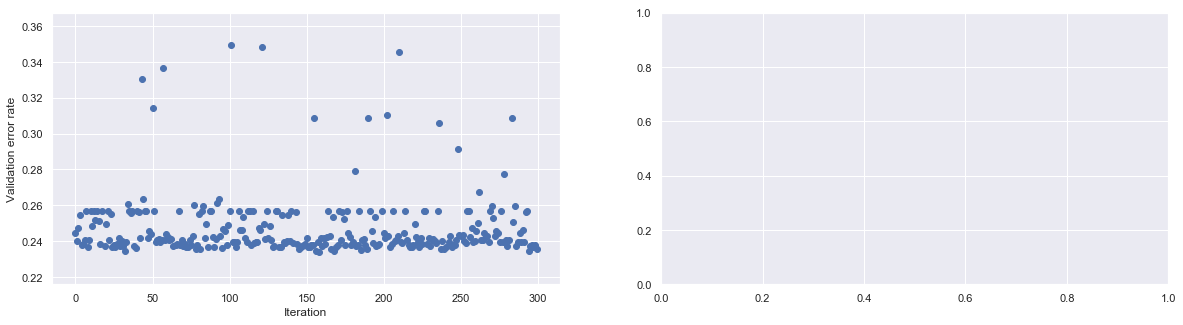

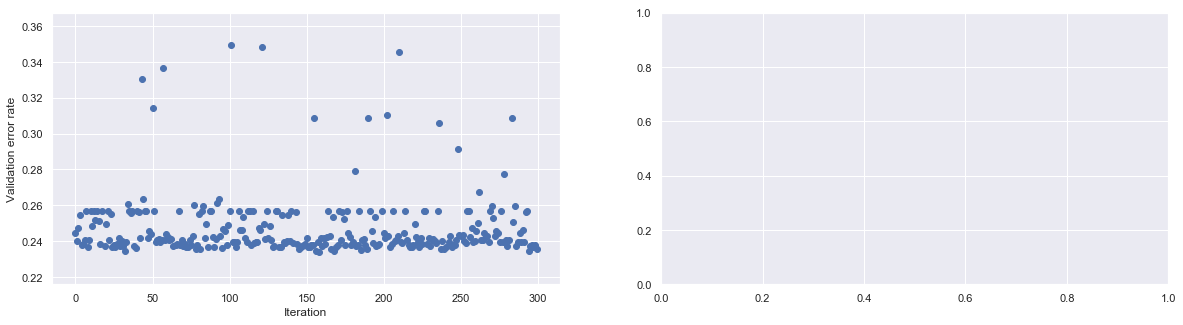

In [26]:
# create generator to assess each step
fit_iterator = estim.fit_iter(X_train, y_train)
next(fit_iterator)

plt.rcParams["figure.figsize"] = (20, 5)
plot_helper = PlotHelper(estim)

while len(estim.trials.trials) < estim.max_evals:
    fit_iterator.send(1) 
    plot_helper.post_iter()

In [27]:
estim.retrain_best_model_on_full_data(X_train, y_train)

Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (12912, 216)
Transforming Xfit (12912, 216)
Training learner RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.488733432326353,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=46,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=253, n_jobs=3, oob_score=False, random_state=42,
            verbose=False, warm_start=False) on X/EX of dimension (12912, 216)


In [29]:
model = estim.best_model()
model

{'learner': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=None, max_features=0.488733432326353,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=46,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=253, n_jobs=3, oob_score=False, random_state=42,
             verbose=False, warm_start=False),
 'preprocs': (StandardScaler(copy=True, with_mean=False, with_std=False),),
 'ex_preprocs': ()}

In [30]:
predictions = estim.predict(X_valid)

score = estim.score(X_valid, y_valid)
score

Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (3992, 216)
Transforming Xfit (3992, 216)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (3992, 216)
Transforming Xfit (3992, 216)


0.7437374749498998

In [31]:
f1_score(y_valid, predictions)

0.05013927576601672

In [32]:
roc_auc_score(y_valid, predictions)

0.5106628230782493

In [33]:
confusion_matrix(y_valid, predictions)

array([[2942,   14],
       [1009,   27]])

## Test Set Performance (Performed Only Once)

In [ ]:
## refit using best model but on entire train & validation sets together

## Interpretation

In [ ]:
def feature_importance(rf, train, pred_cols):
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    predictors = train[pred_cols].columns
    X = train[pred_cols]

    # Print the feature ranking
    print("Feature ranking:")
    #for f in range(X.shape[1]): # all features
    for f in range(5): # top 5 only
        print("%d. %s (%f)" % (f + 1, predictors[indices[f]], importances[indices[f]]))
    
    return X, importances, std, predictors, indices

In [ ]:
x, importances, std, predictors, indices = feature_importance(rf=rf, train=X_train, pred_cols=X_train.columns)

plt.figure(figsize=(20,10)); plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), predictors[indices], rotation=80); plt.xlim([-1, x.shape[1]])
plt.show()

In [ ]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=1000, 
                                 max_features=100, 
                                 random_state=42,
                                 warm_start=True)
gbc.fit(X_train, y_train)

In [ ]:
predictions = gbc.predict(X_valid)
f1_score(y_valid, predictions)

In [ ]:
roc_auc_score(y_valid, predictions)

In [ ]:
plt.rcParams["figure.figsize"] = (15, 15)

var = 'age'
idx = X_train.columns.get_loc(var)

my_plot, ax = plot_partial_dependence(gbc, features=[idx], X=X_train)
axes = plt.gca()
axes.set_xlim([min(X_train[var]), max(X_train[var])])
my_plot.suptitle('Partial dependence on ' + var)